**Path Patel 23AIML055**
<h1>Manufacturing Quality Control With Control Charts</h1>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Data Generation

### 1. Data Generation Function

In [18]:
def simulate_process_data(n_samples=60, base_sample_size=100, p=0.05, shift_point=30, shift_size=0.03):
    if n_samples <= 0 or base_sample_size <= 0 or p < 0 or p > 1 or shift_size < 0 or shift_point < 0 or shift_point > n_samples:
        raise ValueError('Invalid input parameters: Ensure n_samples > 0, base_sample_size > 0, 0 <= p <= 1, shift_size >= 0, and 0 <= shift_point <= n_samples')

    np.random.seed(42)
    dates = pd.date_range(start='2025-01-01', periods=n_samples)
    sample_sizes = np.random.randint(base_sample_size-20, base_sample_size+20, n_samples)

    defects = np.zeros(n_samples)
    true_p = np.full(n_samples, p)

    for i in range(n_samples):
        if i >= shift_point:
            true_p[i] = min(p + shift_size, 1.0)
        defects[i] = np.random.binomial(sample_sizes[i], true_p[i])

    df = pd.DataFrame({
        'Date': dates,
        'Sample_Size': sample_sizes,
        'Defects': defects
    })
    df['Proportion'] = df['Defects'] / df['Sample_Size']

    return df, true_p

### 2. Control Limits Calculation

In [19]:
def calculate_control_limits(data):
    if (data['Sample_Size'] <= 0).any() or (data['Defects'] < 0).any() or (data['Defects'] > data['Sample_Size']).any():
        raise ValueError('Invalid data: Sample sizes must be positive, defects must be non-negative and not exceed sample size')

    p_bar = data['Defects'].sum() / data['Sample_Size'].sum()
    data['CL'] = p_bar
    data['UCL'] = p_bar + 3 * np.sqrt(p_bar * (1 - p_bar) / data['Sample_Size'])
    data['LCL'] = p_bar - 3 * np.sqrt(p_bar * (1 - p_bar) / data['Sample_Size'])

    # Ensure LCL >= 0 and UCL <= 1
    data['LCL'] = data['LCL'].clip(lower=0)
    data['UCL'] = data['UCL'].clip(upper=1)

    return data, p_bar

### 3. Statistical Analysis

In [20]:
def hypothesis_test(data, p_bar, alpha=0.05):
    if not 0 < alpha < 1:
        raise ValueError('Alpha must be between 0 and 1')

    data['P_Value'] = data.apply(lambda row: stats.binomtest(
        int(row['Defects']),
        int(row['Sample_Size']),
        p_bar,
        alternative='two-sided'
    ).pvalue, axis=1)

    data['Out_of_Control'] = (data['P_Value'] < alpha) | \
                            (data['Proportion'] > data['UCL']) | \
                            (data['Proportion'] < data['LCL'])
    return data

### 4. Run Length Analysis

In [21]:
def analyze_run_lengths(data):
    required_columns = ['Out_of_Control', 'Proportion', 'CL']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")

    # Run length for in-control periods
    runs = []
    current_run = 1
    for i in range(1, len(data)):
        if not data['Out_of_Control'].iloc[i-1]:
            current_run += 1
        else:
            if current_run > 1:
                runs.append(current_run)
            current_run = 1
    if current_run > 1:
        runs.append(current_run)

    # Run rules: Check for 8 consecutive points above or below centerline
    above_cl = data['Proportion'] > data['CL']
    below_cl = data['Proportion'] < data['CL']

    def count_consecutive(series):
        max_consecutive = 0
        current_count = 1
        for i in range(1, len(series)):
            if series.iloc[i] and series.iloc[i] == series.iloc[i-1]:
                current_count += 1
                max_consecutive = max(max_consecutive, current_count)
            else:
                current_count = 1
        return max_consecutive

    max_above_cl = count_consecutive(above_cl)
    max_below_cl = count_consecutive(below_cl)

    return {
        'Average Run Length (ARL)': np.mean(runs) if runs else 0,
        'Number of Runs': len(runs),
        'Shortest Run': min(runs) if runs else 0,
        'Longest Run': max(runs) if runs else 0,
        'Max Consecutive Above CL': max_above_cl,
        'Max Consecutive Below CL': max_below_cl,
        'Run Rule Violation (8+ consecutive)': (max_above_cl >= 8) or (max_below_cl >= 8)
    }

### 5. P-Chart Visualization

In [22]:
def plot_p_chart(data, true_p, shift_point=30):
    required_columns = ['Date', 'Proportion', 'CL', 'UCL', 'LCL', 'Out_of_Control']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f'DataFrame must contain columns: {required_columns}')

    plt.figure(figsize=(15, 8))

    # Plot lines
    plt.plot(data['Date'], data['CL'], 'g-', label='Center Line')
    plt.plot(data['Date'], data['UCL'], 'r--', label='UCL')
    plt.plot(data['Date'], data['LCL'], 'r--', label='LCL')
    plt.plot(data['Date'], data['Proportion'], 'bo-', label='Defect Proportion')
    plt.plot(data['Date'], true_p, 'g--', alpha=0.5, label='True Proportion')

    # Highlight out-of-control points
    ooc = data[data['Out_of_Control']]
    plt.plot(ooc['Date'], ooc['Proportion'], 'ro', markersize=10, label='Out of Control')

    # Annotate out-of-control points
    for idx, row in ooc.iterrows():
         plt.annotate(f'{row["Proportion"]:.3f}',
                     (row['Date'], row['Proportion']),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     fontsize=8,
                     color='red')

    # Add vertical line at shift point
    shift_date = data['Date'].iloc[shift_point]
    plt.axvline(x=shift_date, color='purple', linestyle='--', alpha=0.7, label='Process Shift')

    plt.title('P-Chart for Manufacturing Defect Rates')
    plt.xlabel('Date')
    plt.ylabel('Proportion Defective')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 6. Process Capability Analysis

In [23]:
def process_capability_analysis(data, spec_limit=0.1):
    if spec_limit <= 0 or spec_limit > 1:
        raise ValueError('Specification limit must be between 0 and 1')
    if 'Proportion' not in data.columns:
        raise ValueError("DataFrame must contain 'Proportion' column")

    p_bar = data['Proportion'].mean()
    sigma = np.sqrt(p_bar * (1 - p_bar) / data['Sample_Size'].mean())

    cp = (spec_limit - p_bar) / (3 * sigma) if sigma > 0 else float('inf')

    return {
        'Average Proportion': p_bar,
        'Process Sigma': sigma,
        'Cp': cp,
        'Meets Specification': cp >= 1.33
    }

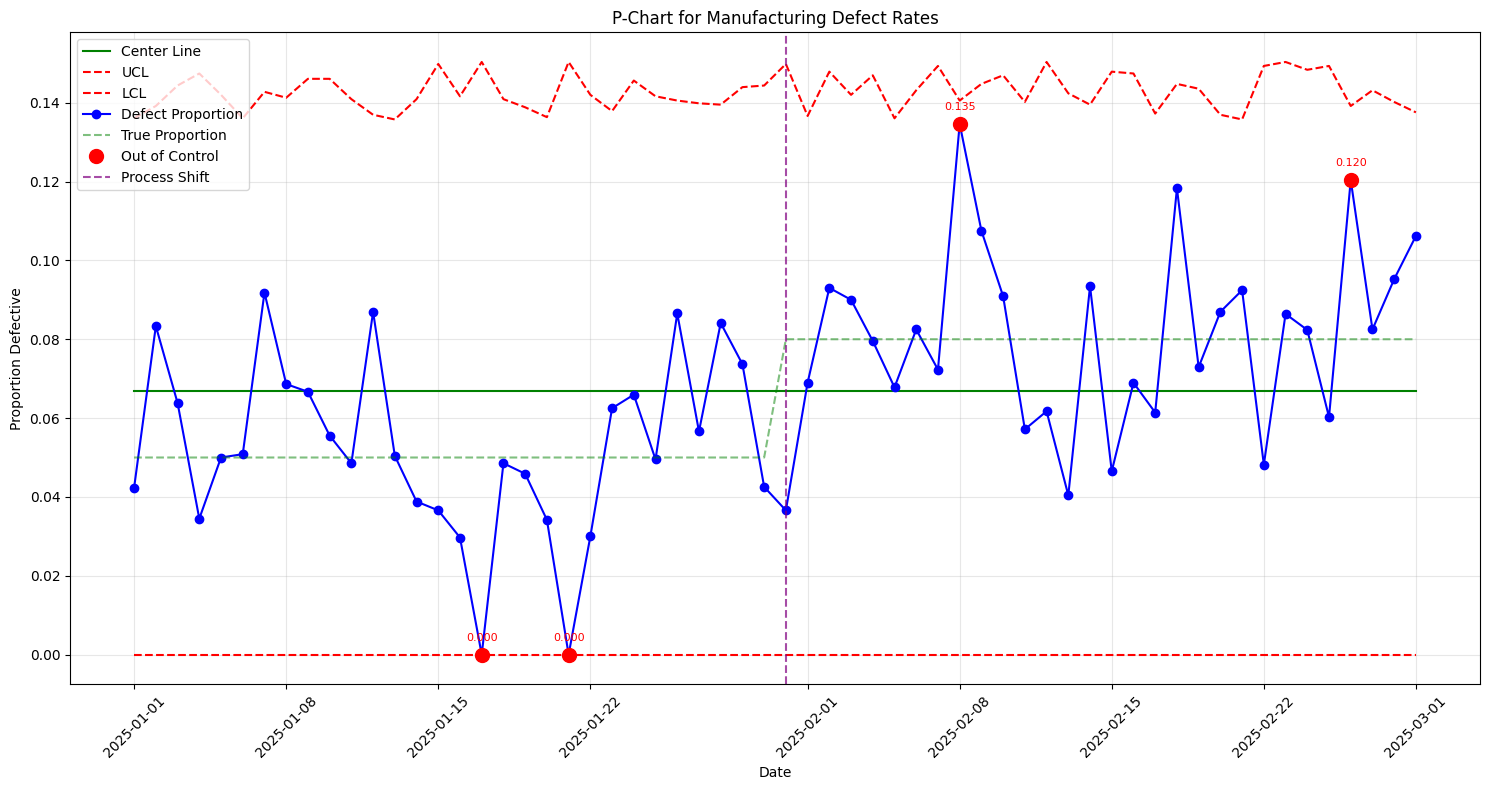

In [24]:
# Simulate data
df, true_p = simulate_process_data()

# Calculate control limits
df, p_bar = calculate_control_limits(df)

# Perform hypothesis testing
df = hypothesis_test(df, p_bar)

# Analyze run lengths
run_stats = analyze_run_lengths(df)

# Perform process capability analysis
capability_stats = process_capability_analysis(df)

# Plot p-chart with annotations and shift point
plot_p_chart(df, true_p)

### P-Chart Analysis Summary

1. **Change in Process Performance**:
   - The process shows a noticeable shift starting at the purple dashed line (Day 30).
   - The proportion of defects rises from around 5% to nearly 8%.

2. **Out-of-Control Signals**:
   - Red markers represent points outside the control limits.
   - These points are labeled with their defect rates.
   - Multiple data points after the shift cross the Upper Control Limit (UCL), indicating process instability.

3. **Control Limit Interpretation**:
   - The green line represents the overall average defect rate (center line).
   - Red dashed lines mark the UCL and LCL (±3 standard deviations).
   - The width of the control limits varies due to different sample sizes per day.

In [25]:
# Print summary statistics
print("Control Chart Summary:")
print(f"Center Line: {p_bar:.4f}")
print(f"Number of Out-of-Control Points: {df['Out_of_Control'].sum()}")

print("\nRun Length Analysis:")
for key, value in run_stats.items():
    print(f"{key}: {value:.2f}")

print("\nProcess Capability Analysis:")
for key, value in capability_stats.items():
    print(f"{key}: {value if isinstance(value, bool) else f'{value:.4f}'}")

print("\nData Preview:")
print(df.head())

Control Chart Summary:
Center Line: 0.0670
Number of Out-of-Control Points: 4

Run Length Analysis:
Average Run Length (ARL): 12.00
Number of Runs: 5.00
Shortest Run: 3.00
Longest Run: 18.00
Max Consecutive Above CL: 10.00
Max Consecutive Below CL: 13.00
Run Rule Violation (8+ consecutive): 1.00

Process Capability Analysis:
Average Proportion: 0.0664
Process Sigma: 0.0250
Cp: 0.4476
Meets Specification: 0.0000

Data Preview:
        Date  Sample_Size  Defects  Proportion        CL       UCL  LCL  \
0 2025-01-01          118      5.0    0.042373  0.066992  0.136037  0.0   
1 2025-01-02          108      9.0    0.083333  0.066992  0.139163  0.0   
2 2025-01-03           94      6.0    0.063830  0.066992  0.144351  0.0   
3 2025-01-04           87      3.0    0.034483  0.066992  0.147403  0.0   
4 2025-01-05          100      5.0    0.050000  0.066992  0.141995  0.0   

    P_Value  Out_of_Control  
0  0.358244           False  
1  0.441847           False  
2  1.000000           False  

In [26]:
def perform_cusum_analysis(data, target=None, k=0.005, h=0.05):
    if target is None:
        target = data['Proportion'].mean()

    cusum_pos = [0]
    cusum_neg = [0]

    for i in range(1, len(data)):
        p_i = data.iloc[i]['Proportion']

        s_pos = max(0, cusum_pos[-1] + (p_i - target - k))
        s_neg = max(0, cusum_neg[-1] - (p_i - target + k))

        cusum_pos.append(s_pos)
        cusum_neg.append(s_neg)

    data = data.copy()
    data['CUSUM_pos'] = cusum_pos
    data['CUSUM_neg'] = cusum_neg
    data['CUSUM_Signal'] = (data['CUSUM_pos'] > h) | (data['CUSUM_neg'] > h)

    return data

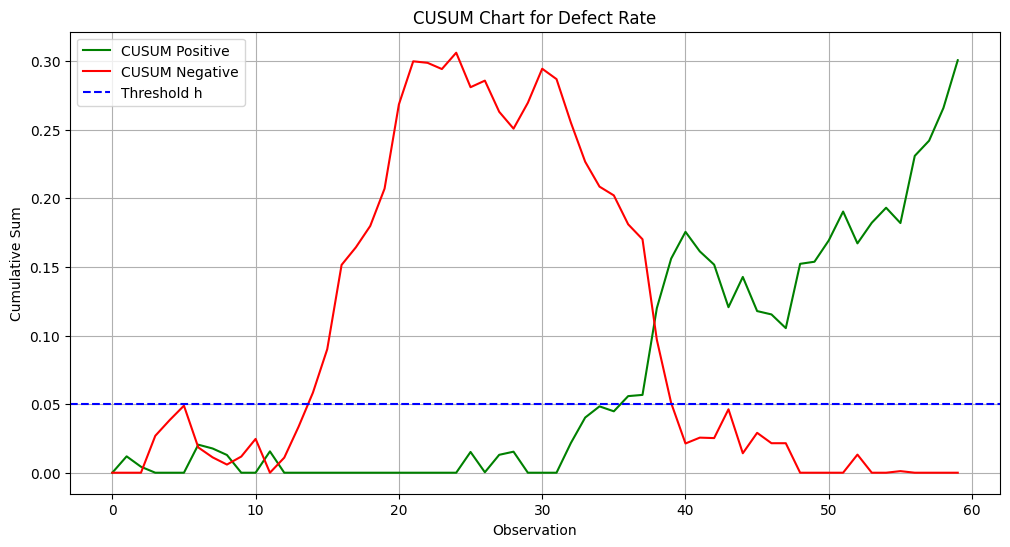

In [27]:
# Perform CUSUM analysis
df = perform_cusum_analysis(df)

# Plot CUSUM chart
plt.figure(figsize=(12, 6))
plt.plot(df['CUSUM_pos'], label='CUSUM Positive', color='green')
plt.plot(df['CUSUM_neg'], label='CUSUM Negative', color='red')
plt.axhline(0.05, color='blue', linestyle='--', label='Threshold h')
plt.title('CUSUM Chart for Defect Rate')
plt.xlabel('Observation')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.grid(True)
plt.show()

### CUSUM Chart Summary

1. **Quick Shift Detection**:
   - The green line (CUSUM+) tracks when defect rates go above the target.
   - The red line (CUSUM−) tracks when defect rates fall below the target.
   - The blue dashed line marks the decision boundary (h = 0.05).

2. **Trend Observation**:
   - A rising CUSUM+ line after the shift shows a continuous increase in defect levels.
   - This trend confirms the process has moved to a worse state.
   - The chart is more sensitive to small changes than a regular P-chart.

3. **Higher Detection Capability**:
   - CUSUM is designed to find small process shifts that might be missed by standard charts.
   - It gives an earlier alert when the process starts to degrade.


In [28]:
def perform_ewma_analysis(data, lambda_=0.2, L=3):
    data = data.copy()
    # Initialize EWMA
    data['EWMA'] = 0.0
    data.loc[0, 'EWMA'] = data.loc[0, 'Proportion']

    # Compute EWMA for each point
    for i in range(1, len(data)):
        data.loc[i, 'EWMA'] = lambda_ * data.loc[i, 'Proportion'] + \
                             (1 - lambda_) * data.loc[i-1, 'EWMA']

    # Calculate control limits
    p_bar = data['Proportion'].mean()
    sigma = np.sqrt(p_bar * (1 - p_bar) / data['Sample_Size'].mean())

    data['UCL_EWMA'] = p_bar + L * sigma * \
        np.sqrt((lambda_ / (2 - lambda_)) * (1 - (1 - lambda_)**(2 * (data.index + 1))))
    data['LCL_EWMA'] = p_bar - L * sigma * \
        np.sqrt((lambda_ / (2 - lambda_)) * (1 - (1 - lambda_)**(2 * (data.index + 1))))

    return data

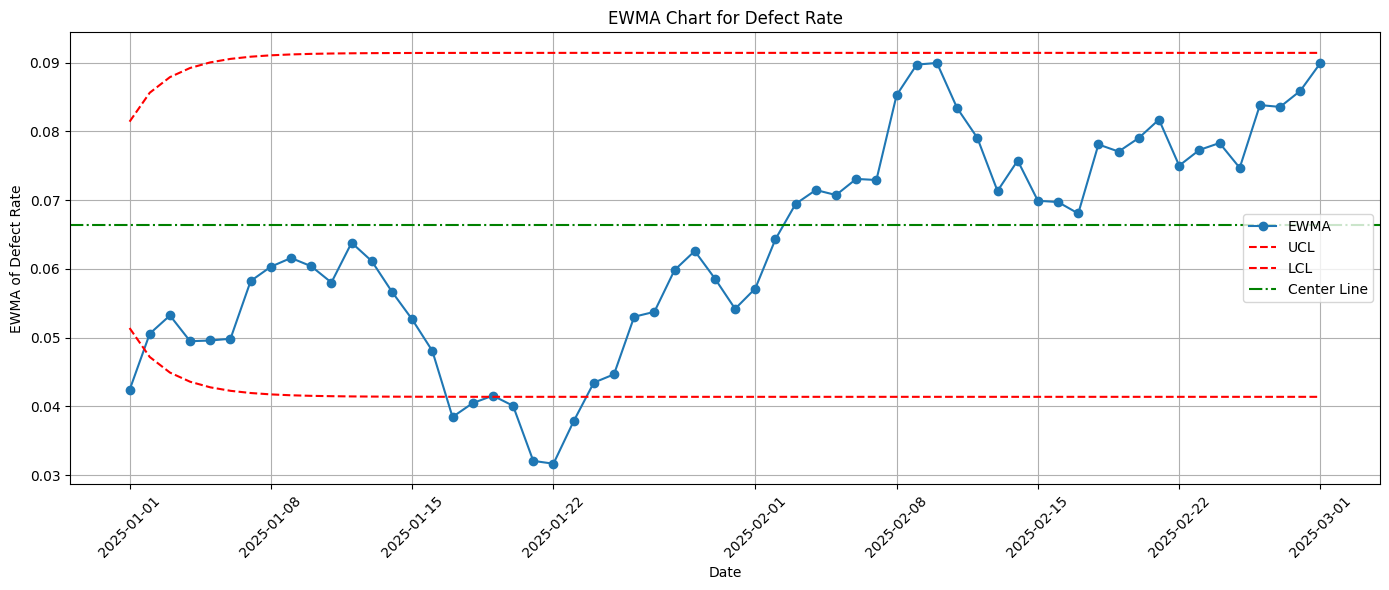

In [29]:
# Perform EWMA analysis
df = perform_ewma_analysis(df)

# Plot EWMA chart
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['EWMA'], marker='o', label='EWMA')
plt.plot(df['Date'], df['UCL_EWMA'], linestyle='--', color='red', label='UCL')
plt.plot(df['Date'], df['LCL_EWMA'], linestyle='--', color='red', label='LCL')
plt.axhline(df['Proportion'].mean(), color='green', linestyle='-.', label='Center Line')
plt.title('EWMA Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('EWMA of Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### EWMA Chart Summary
1. **Smoother Trend Tracking**:
   - The blue line represents the exponentially smoothed average of the defect rate.
   - It reduces random variation (noise) in the data.
   - Makes it easier to observe overall trends in the process.

2. **Adaptive Control Limits**:
   - Red dashed lines show control limits that adjust over time.
   - These limits are narrower than those in a P-chart.
   - This makes the chart more sensitive to gradual, ongoing shifts.

3. **Identifying Process Drift**:
   - After the shift point, the chart shows a steady upward movement.
   - It reacts less to isolated spikes (outliers).
   - Useful for detecting slow, continuous changes in the process.


In [30]:
def analyze_trend(data):
    data = data.copy()
    data['Day'] = range(1, len(data) + 1)

    trend_result = stats.linregress(data['Day'], data['Proportion'])
    slope = trend_result.slope
    p_value = trend_result.pvalue
    data['Trend_Line'] = trend_result.intercept + slope * data['Day']

    return slope, p_value, data

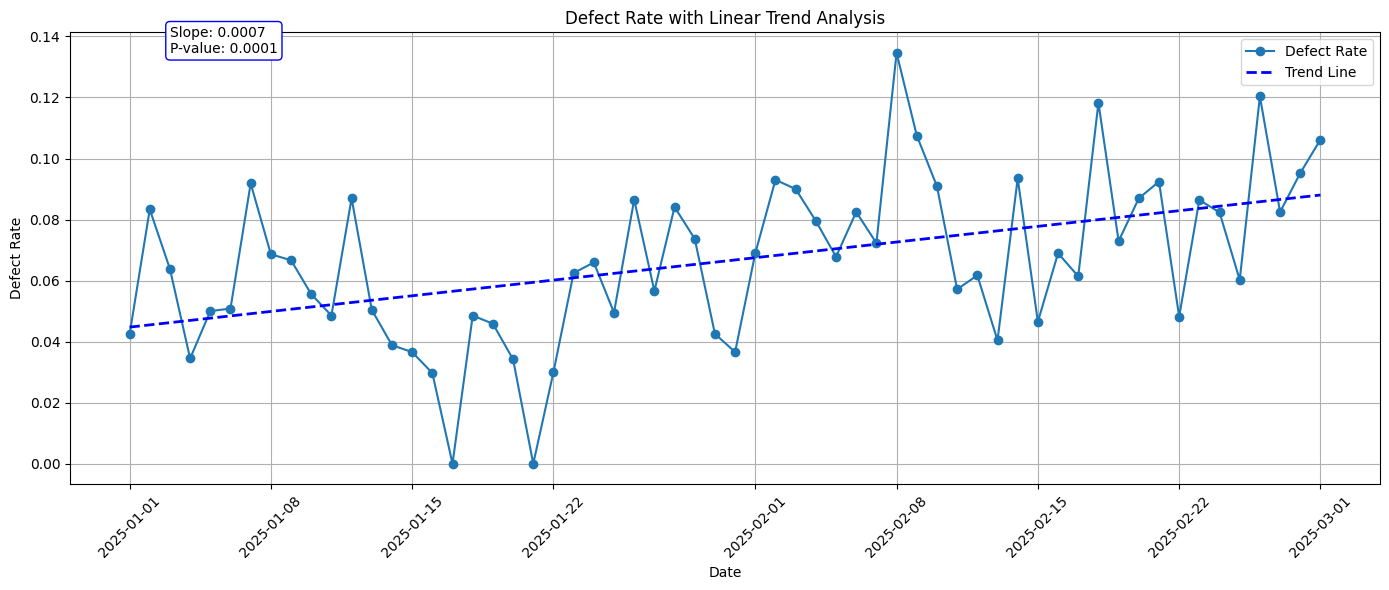

In [31]:
# Perform trend analysis
slope, p_value, df = analyze_trend(df)

# Plot trend analysis
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Proportion'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['Trend_Line'], linestyle='--', color='blue', linewidth=2, label='Trend Line')

plt.text(df['Date'].iloc[2], max(df['Proportion']),
         f"Slope: {slope:.4f}\nP-value: {p_value:.4f}",
         fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round'))

plt.title('Defect Rate with Linear Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Linear Trend Analysis Summary

1. **Fitted Trend Line**:
   - The blue dashed line shows a straight-line fit to the data.
   - An upward slope means the defect rate is increasing over time.
   - This line helps measure how quickly the process is getting worse.

2. **Statistical Testing**:
   - The chart includes the slope and p-value.
   - A low p-value means the trend is statistically significant (not due to random noise).
   - Confirms that the change in the process is real and consistent.

3. **Visual Insight**:
   - The chart makes it easy to see the overall direction of the process.
   - Adds value to control charts by showing long-term trends.
   - Useful for identifying steady deterioration in quality over time.
